<b> Run following cell with pip once when you create a new cloud enviroment </b>

In [1]:
%%capture
!pip install numba==0.48.0 sklearn plotly

<b> Restart notebook kernel after installing the three packages above </b>

<b> Above cells don't need to be run again unless you reset your cloud environment </b>

---

## Imports and Inputs
and initialize Hail

In [4]:
#Install Hail
from firecloud import fiss
import hail as hl

#Import libraries for the ancestry inference 
import math as math
import pandas as pd

from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate  # this line changed from Saud's notebook since the most
#updated version of sklearn requires to import this from model_selection
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from bokeh.io import output_notebook, show

import seaborn
import plotly.express as px

#initialize hail
hl.init()
output_notebook()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-02-09 20:58:54 WARN  Hail:43 - This Hail JAR was compiled for Spark 3.1.1, running with Spark 3.1.2.
  Compatibility is not guaranteed.


Running on Apache Spark version 3.1.2
SparkUI available at http://saturn-60725431-fd1b-4124-abaf-e029612aae13-m.c.vanallen-aldubayan-lab.internal:46527
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.74-0c3a74d12093
LOGGING: writing to /home/jupyter/arab_breast_cancer_analysis/edit/hail-20220209-2058-0.2.74-0c3a74d12093.log


Loading BokehJS ...

### Inputs
    All intermediate and final outout files will be stored in the google bucket path set in the variable "bucket".
    If you are not using a bucket of a workspace that has opted out of cleaner bot, outputs from this notebook
    might be deleted by Brendan's cleaner-bot.

In [ ]:
# Used as the path base for the full_merged_vcf and notebook outputs
bucket = 'gs://fc-4381da00-c3cd-4a57-8334-32d78506f6e6/49accfe1-b0dd-40e5-b9c8-d32fabdd67a0/Ancestry_Inference/fbbccfe4-459e-4aed-bd54-2233ea51b0cf/call-CombineVariants/'

# cases
cohort_name ="MID_BC_Female_Only_No_Related"
#  contains cases, control, and ref (1kg)
full_merged_vcf = bucket + "MID_BC_QATR_WES_MID_Ciliopathies_female_only_1000g_merged.vcf.gz"

# control
control_name = "QATR_WES_MID_Ciliopathies_Female_Only_No_Related"
#  contains control and ref (1kg)
control_ref_vcf = "gs://fc-4381da00-c3cd-4a57-8334-32d78506f6e6/f743b494-4ff1-4bf5-a9d9-590c2d3eb9da/Subset_VCF/7937c2d9-635a-44f8-98a8-6928ebd73669/call-GATKSelectVariants/QATR_WES_MID_Ciliopathies_MID_BC_Combined_All.subset.vcf.gz"

# reference (only 1kg here, appears in variable names later)
ref_name = "1KG"
ref_vcf = "gs://fc-e4808678-a557-43c2-b46e-20385d5c64f0/0f2fdd10-7168-4d73-94ce-b55475827599/VT_Decomp/e9cf326c-c7b9-4d26-b0c1-7f4270adc4d2/call-VTRecal/Jul2021_1000g_3202_WGS_DV_merged.vt2_normalized_spanning_alleles.vcf.gz"

thousand_G_clinical_info = "gs://fc-86adf333-cc1a-4027-9e69-fd0433d63d1c/hg38_references/supercohort_combined_with_info.txt"



##  Load input vcfs
    

In [5]:
#%%time

# TODO don't import these massive vcfs for their headers
#   we should have a list of cases and controls available to label as such

# thousand genomes vcf
thousand_G_mt = hl.import_vcf(ref_vcf, n_partitions=200, reference_genome='GRCh38', force_bgz= True)
thousand_G_sample_list = thousand_G_mt.s.collect()
del thousand_G_mt

# make a list of control samples and the name of the file
control_mt = hl.import_vcf(control_ref_vcf, n_partitions=200, reference_genome='GRCh38', force_bgz=True)
control_sample_list = control_mt.s.collect()
control_sample_list = list(set(control_sample_list) - set(thousand_G_sample_list))
del control_mt

# import the merged vcf, list cases
merged_mt = hl.import_vcf(full_merged_vcf, n_partitions=200, reference_genome='GRCh38', force_bgz=True)
merged_sample_list = merged_mt.s.collect()
case_sample_list = list(set(merged_sample_list) - set(thousand_G_sample_list) - set(control_sample_list))
case_sample_table = pd.DataFrame({"sample_original" : [case_sample_list, control_sample_list, thousand_G_sample_list],
                                  "cohort" : [cohort_name, 'control', 'control']},
                                 columns=['sample_original', 'cohort'])

2022-02-09 21:03:11 Hail: INFO: Coerced almost-sorted dataset==>(198 + 2) / 200]
2022-02-09 21:03:16 Hail: INFO: Coerced almost-sorted dataset=> (193 + 7) / 200]
2022-02-09 21:03:31 Hail: INFO: Coerced almost-sorted dataset==>(199 + 1) / 200]


CPU times: user 320 ms, sys: 58 ms, total: 378 ms
Wall time: 58.9 s


##  1st Round of PCA and Random Forest Ancestry Inference

### Variant filtering and LD pruning

In [ ]:
def filtering(input_mt):
    filtered_mt = hl.variant_qc(input_mt)
    filtered_mt = filtered_mt.filter_rows(filtered_mt.variant_qc.AF[1] > 0.01) # Rare variant filter
    filtered_mt = filtered_mt.filter_rows(filtered_mt.variant_qc.p_value_hwe > 1e-6) # Hardy-Weinberg Equilibrium filter
    variants_after_pruning = hl.ld_prune(filtered_mt.GT, r2=0.1)   # Pruning 
    filtered_mt = filtered_mt.filter_rows(hl.is_defined(variants_after_pruning[filtered_mt.row_key]))

    return filtered_mt

principal_components = ['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10']

In [6]:
#%%time 

# Assign HOM REF to missing genotypes 
merged_mt = merged_mt.annotate_entries(GT = hl.if_else(hl.is_defined(merged_mt.GT), merged_mt.GT, hl.Call([0, 0])))

filtered_mt = filtering(merged_mt)

print("Filtering and Pruning Done")
print("Number of variants (and samples) after filtering is")
print(filtered_mt.count())

2022-02-09 21:03:47 Hail: INFO: ld_prune: running local pruning stage with max queue size of 52801 variants
2022-02-09 21:04:02 Hail: INFO: Coerced almost-sorted dataset==>(199 + 1) / 200]
2022-02-09 21:09:19 Hail: INFO: wrote table with 59086 rows in 200 partitions to /tmp/vZaNKRbabdrAIdSESTjda9
    Total size: 1.80 MiB
    * Rows: 1.80 MiB
    * Globals: 11.00 B
    * Smallest partition: 7 rows (338.00 B)
    * Largest partition:  406 rows (12.40 KiB)
2022-02-09 21:10:07 Hail: INFO: Coerced almost-sorted dataset==>(199 + 1) / 200]
2022-02-09 21:17:03 Hail: INFO: Wrote all 30 blocks of 59086 x 4881 matrix with block size 4096.
2022-02-09 21:20:13 Hail: INFO: wrote table with 576 rows in 29 partitions to /tmp/khZVWBZqVHjMONWIHq2IYp
    Total size: 670.88 KiB
    * Rows: 13.09 KiB
    * Globals: 657.79 KiB
    * Smallest partition: 0 rows (21.00 B)
    * Largest partition:  68 rows (1.43 KiB)


Number of variants (and samples) after filtering is 


2022-02-09 21:20:47 Hail: INFO: Coerced almost-sorted dataset==>(199 + 1) / 200]


(58587, 4881)
filtering and pruning done
CPU times: user 3.78 s, sys: 393 ms, total: 4.17 s
Wall time: 18min 54s


### PCA

In [ ]:
#%%time
pca_eigenvalues, pca_scores, _ = hl.hwe_normalized_pca(filtered_mt.GT)
print("PCA done")

### Data Prep

In [ ]:
pca_scores = pca_scores.to_pandas()                              # convert to pandas table
pca_scores[principal_components] = pca_scores.scores.to_list()   # split the scores column
pca_scores.drop(columns="scores", inplace=True)                  # remove the scores column
pca_scores.rename(columns={"s":"sample_original"}, inplace=True) # rename the first column

# import clinical data
clinical_info_1KG = hl.import_table(thousand_G_clinical_info).to_pandas()

# merge the PCA with the clinical data
pca_scores_pd_clinical = pd.merge(pca_scores, clinical_info_1KG, on='sample_original', how="left")

# add cohort labels to cases and controls
sample_original = pca_scores_pd_clinical.sample_original
pca_scores_pd_clinical.loc[sample_original.isin(control_sample_list), 'Super_Population'] = control_name
pca_scores_pd_clinical.loc[sample_original.isin(case_sample_list), 'Super_Population'] = cohort_name

### Random Forest

In [7]:
# create datasets for training and testing (split on 1000 genomes samples)
sample_mask_1kg = sample_original.isin(thousand_G_sample_list)

training_data = pca_scores_pd_clinical[sample_mask_1kg]
testing_data = pca_scores_pd_clinical[~sample_mask_1kg]


# define the variables that we want to use to build the model
#   replacing population tags with integers for training
predictor_variables_PCA = principal_components
x_PCA = training_data[predictor_variables_PCA]
y = training_data.Super_Population.replace(['EUR', 'AFR', 'EAS', 'SAS', 'AMR'], [1,2,3,4,5]).to_list()


# ini with parameters
modelRandom_PCA = RandomForestClassifier()

# cross validation: (5 fold)
modelRandomCV_PCA = cross_val_score(modelRandom_PCA, x_PCA, y, cv=5)
modelRandom_PCA.fit(x_PCA, y)

# predict the unknown ancestry
ancestry_inference_PCA = modelRandom_PCA.predict(testing_data[predictor_variables_PCA])

# combine back with the testing data
testing_data["inferred_ancestry_PCA"] = ancestry_inference_PCA

# convert the numbers back into ancestry categories
testing_data.inferred_ancestry_PCA.replace([1,2,3,4,5], ['EUR', 'AFR', 'EAS', 'SAS', 'AMR'], inplace=True)

# save all the relevant files so you wont have to run this cell again!
#  TODO check if these are ever intended to be human readable, otherwise use a more compressed format
testing_data.to_csv('testing_data.csv', index=False, sep='\t')
training_data.to_csv('training_data.csv', index=False, sep='\t')
pca_scores_pd_clinical.to_csv('pca_scores_pd_clinical.csv', index=False, sep='\t')

!gsutil cp "testing_data.csv" $bucket
!gsutil cp "training_data.csv" $bucket
!gsutil cp "pca_scores_pd_clinical.csv" $bucket

2022-02-09 21:23:17 Hail: INFO: Coerced almost-sorted dataset==>(199 + 1) / 200]
2022-02-09 21:25:10 Hail: INFO: hwe_normalized_pca: running PCA using 58587 variants.
2022-02-09 21:25:23 Hail: INFO: Coerced almost-sorted dataset==>(198 + 2) / 200]
2022-02-09 21:27:14 Hail: INFO: pca: running PCA with 10 components... 1) / 200]
2022-02-09 21:31:28 Hail: WARN: Name collision: field 'sample' already in object dict. 
  This field must be referenced with __getitem__ syntax: obj['sample']
2022-02-09 21:31:28 Hail: INFO: Reading table without type imputation
  Loading field 'Population_Code' as type str (not specified)
  Loading field 'sample_original' as type str (not specified)
  Loading field 'Family_ID' as type str (not specified)
  Loading field 'Gender' as type str (not specified)
  Loading field 'Population Description' as type str (not specified)
  Loading field 'Super_Population' as type str (not specified)
  Loading field 'Sequence Data Available' as type str (not specified)
  Loadi

PCA done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/l

Copying file://testing_data.txt [Content-Type=text/plain]...
/ [1 files][458.7 KiB/458.7 KiB]                                                
Operation completed over 1 objects/458.7 KiB.                                    
Copying file://training_data.txt [Content-Type=text/plain]...
/ [1 files][903.5 KiB/903.5 KiB]                                                
Operation completed over 1 objects/903.5 KiB.                                    
Copying file://pca_scores_pd_clinical.txt [Content-Type=text/plain]...
/ [1 files][  1.3 MiB/  1.3 MiB]                                                
Operation completed over 1 objects/1.3 MiB.                                      
CPU times: user 4.24 s, sys: 312 ms, total: 4.55 s
Wall time: 8min 38s


### Interlude

<b> IF YOU WANT TO INCLUDE 1000G IN YOUR VISUALIZATION, RUN THIS CELL. IF NOT, DONT :) </b>

In [ ]:
training_data['inferred_ancestry_PCA'] = training_data['Super_Population']
training_data['Super_Population'] = '1000G'
testing_data = pd.concat([training_data, testing_data])
  # TODO test if this is unecessary since these views should have just modified the underlying dataframe

<b> Run from below cell if your notebook runtime was deleted before running next steps </b>

In [4]:
!gsutil cp $bucket/testing_data.txt .
!gsutil cp $bucket/training_data.txt .
!gsutil cp $bucket/pca_scores_pd_clinical.txt .

testing_data = pd.read_table("./testing_data.csv", sep="\t")
training_data = pd.read_table("./training_data.csv", sep="\t")
pca_scores_pd_clinical = pd.read_table("./pca_scores_pd_clinical.csv", sep="\t")

Copying gs://fc-a32996b4-1a46-4467-9f74-20714c5d2f96/854e14cf-b7db-4224-bbf2-4415782456bb/CombineVariants_workflow/dad8d8b3-e22d-48b8-9ea5-0135acd0c54b/call-mergechromvcfs/082421_hail_nomissing_pca.txt...
Copying gs://fc-a32996b4-1a46-4467-9f74-20714c5d2f96/854e14cf-b7db-4224-bbf2-4415782456bb/CombineVariants_workflow/dad8d8b3-e22d-48b8-9ea5-0135acd0c54b/call-mergechromvcfs/082421_hail_original.txt...
Copying gs://fc-a32996b4-1a46-4467-9f74-20714c5d2f96/854e14cf-b7db-4224-bbf2-4415782456bb/CombineVariants_workflow/dad8d8b3-e22d-48b8-9ea5-0135acd0c54b/call-mergechromvcfs/082421_hail_original_01.txt...
Copying gs://fc-a32996b4-1a46-4467-9f74-20714c5d2f96/854e14cf-b7db-4224-bbf2-4415782456bb/CombineVariants_workflow/dad8d8b3-e22d-48b8-9ea5-0135acd0c54b/call-mergechromvcfs/082421_hail_original_02.txt...
/ [4 files][221.0 KiB/221.0 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instea

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (11,12,13,14,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Visualize PCA and Ancestry Inference

In [10]:
# TODO resume here for first pass cleaning
## setting up plotnames to save, CHANGE TO YOUR OWN COHORT

def plotname(purpose):
    name = purpose + 'Aug2021_RCC_discovery' + '.png'
    return name

plotname('controls_barplot')

## you will set the purpose variable in each plotting cell, so that you can change the name of the output file! 
## i copied these lines to a couple of plots but not all, so you can add to the ones youd like to save and copy to the bucket

'controls_barplotAug2021_RCC_discovery.png'

In [8]:
#Set order of bars and color scheme for 5 continental ancestry groups 

order=["EUR","AFR","EAS","AMR","SAS"]
palette ={"EUR": "royalblue", "AFR": "chocolate", "EAS": "darkred", "SAS": "darkgreen","AMR":"blueviolet"}

In [9]:
#Ancestry Inference barplot for control

savethis = plotname('controls_barplot_')

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) 
bp=seaborn.countplot(data=testing_data[(testing_data.Super_Population==control_name) | (testing_data.Super_Population=='1000G')]
                     ,order=order,palette=palette,x='inferred_ancestry_PCA')

for p in bp.patches:
    bp.annotate(format(p.get_height(), ''), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title("Ancestry Inference for "+ control_name)

plt.savefig(savethis, bbox_inches='tight', dpi = 500)
!gsutil cp $savethis $bucket

NameError: name 'plotname' is not defined

Copying file://cases_barplot_Aug2021_RCC_discovery.png [Content-Type=image/png]...
/ [1 files][233.8 KiB/233.8 KiB]                                                
Operation completed over 1 objects/233.8 KiB.                                    


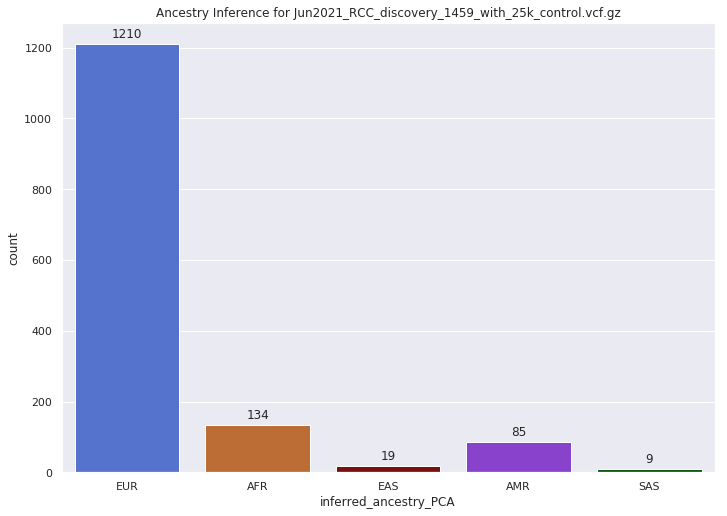

In [17]:
#Ancestry Inference barplot for case
#order2=['EUR', 'AFR', 'SAS','EAS','AMR'] In case you don't have all 5 ancestry groups in cases, change this order list


savethis = plotname('cases_barplot_')
bp2=seaborn.countplot(data=testing_data[testing_data.Super_Population==cohort_name],
                      order=order,palette=palette,x='inferred_ancestry_PCA')

for p in bp2.patches:
    bp2.annotate(format(p.get_height(), ''), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title("Ancestry Inference for "+ cohort_name)

plt.savefig(savethis, bbox_inches='tight', dpi = 500)
!gsutil cp $savethis $bucket

Text(0.5, 0.98, 'Continental ancestry inference PC1 vs PC2')

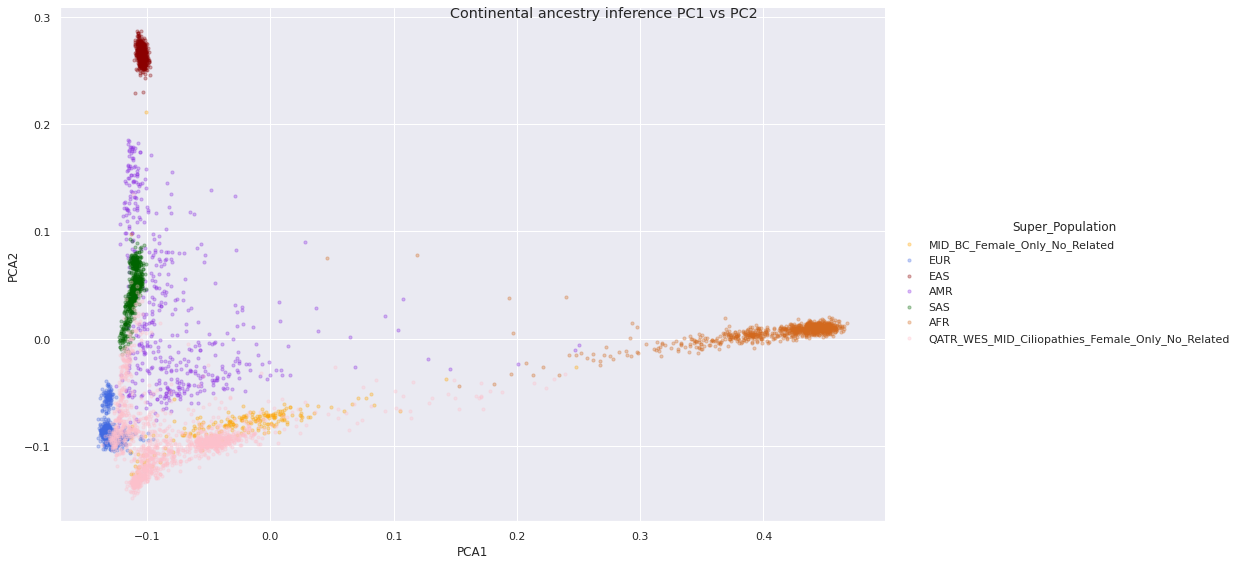

In [10]:
#Figure 1 - Continental Ancestry PC1 vs PC2 

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) 
fg = seaborn.FacetGrid(data=pca_scores_pd_clinical, hue='Super_Population',height=8 , aspect=1.61,
                      palette ={"EUR": "royalblue", "AFR": "chocolate", "EAS": "darkred", "SAS": "darkgreen","AMR":"blueviolet",cohort_name:"orange",control_name:"pink"})
fg.map(plt.scatter, 'PCA1', 'PCA2',alpha=0.3,s=10).add_legend()
fg.fig.suptitle("Continental ancestry inference PC1 vs PC2")

Text(0.5, 0.98, 'Continental ancestry inference PC2 vs PC3')

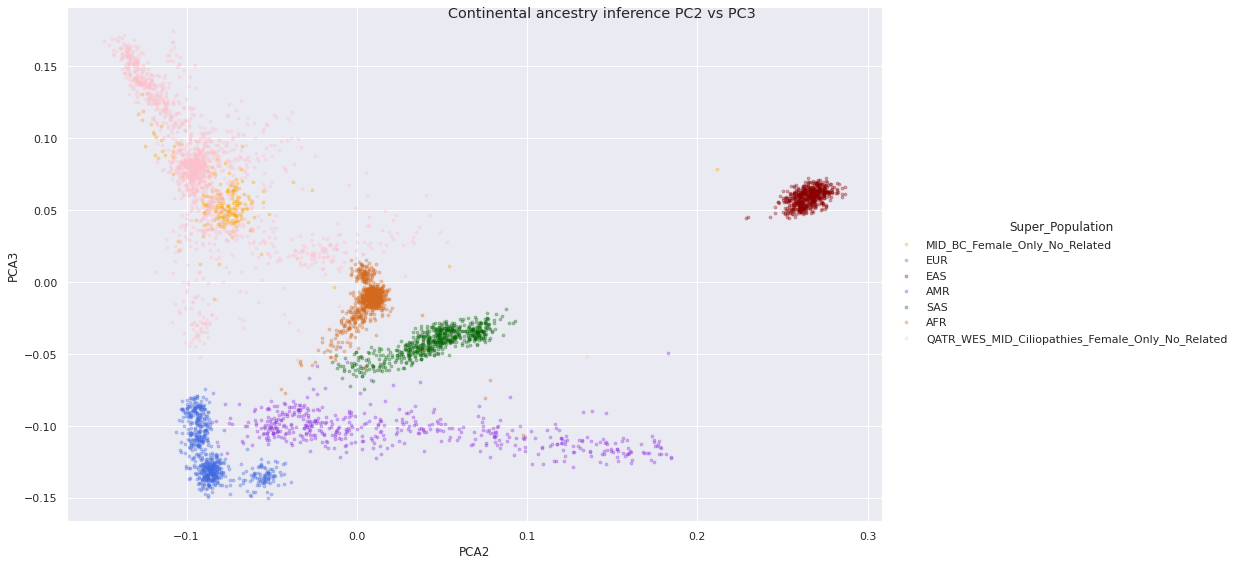

In [11]:
#Figure 2 - Continental Ancestry PC2 vs PC3 

fg = seaborn.FacetGrid(data=pca_scores_pd_clinical, hue='Super_Population', height=8,aspect=1.61,
                      palette ={"EUR": "royalblue", "AFR": "chocolate", "EAS": "darkred", "SAS": "darkgreen","AMR":"blueviolet",cohort_name:"orange",control_name:"pink"})
fg.map(plt.scatter, 'PCA2', 'PCA3',alpha=0.3,s=8).add_legend()
fg.fig.suptitle("Continental ancestry inference PC2 vs PC3")
#fg.set(xlim=(-0.03,0.08))
#fg.set(ylim=(-0.02,0.02))

Text(0.5, 0.98, 'Continental ancestry inference PC1 vs PC3')

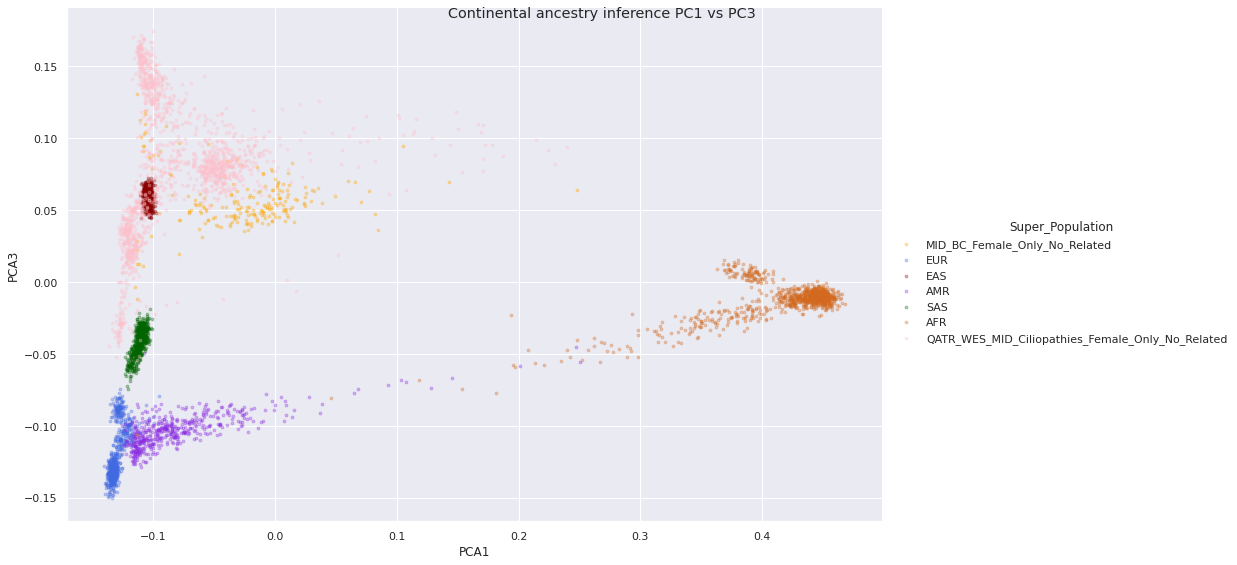

In [12]:
#Figure 3 - Continental Ancestry PC1 vs PC3 

fg = seaborn.FacetGrid(data=pca_scores_pd_clinical, hue='Super_Population', height=8,aspect=1.61,
                      palette ={"EUR": "royalblue", "AFR": "chocolate", "EAS": "darkred", "SAS": "darkgreen","AMR":"blueviolet",cohort_name:"orange",control_name:"pink"})
fg.map(plt.scatter, 'PCA1', 'PCA3',alpha=0.3,s=8).add_legend()
fg.fig.suptitle("Continental ancestry inference PC1 vs PC3")
#fg.set(xlim=(-0.03,0.08))
#fg.set(ylim=(-0.07,0.07))

## 2nd Round of PCA and ancestry matching 

<b> 4-1. Divide case/control into smaller matrix tables of each ancestry </b>

In [ ]:
### 4-1-MID. Override labels of cases and controls into MID

In [18]:
testing_data.loc[testing_data['Super_Population'].isin([cohort_name,control_name]),'inferred_ancestry_PCA'] = "MID"
testing_data

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,sample_original,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,Population_Code,Family_ID,Gender,Population_Description,Super_Population,Sequence_Data_Available,Alignment_Data_Available,Variant_Data_Available,sample,inferred_ancestry_PCA
0,BC_P_001,-0.065655,-0.090977,0.056844,-0.009378,0.009412,0.014486,0.005328,-0.027350,-0.050060,...,NaN,NaN,NaN,NaN,MID_BC_Female_Only_No_Related,NaN,NaN,NaN,NaN,MID
1,BC_P_002,0.016047,-0.063784,0.041954,-0.002997,0.005466,0.001540,0.024597,-0.054365,-0.025383,...,NaN,NaN,NaN,NaN,MID_BC_Female_Only_No_Related,NaN,NaN,NaN,NaN,MID
2,BC_P_003,0.009184,-0.066815,0.050714,-0.001747,0.008062,0.008161,0.011414,-0.061011,-0.044091,...,NaN,NaN,NaN,NaN,MID_BC_Female_Only_No_Related,NaN,NaN,NaN,NaN,MID
3,BC_P_004,-0.069269,-0.087976,0.049845,-0.012878,-0.005330,0.008429,0.014916,-0.034220,-0.050338,...,NaN,NaN,NaN,NaN,MID_BC_Female_Only_No_Related,NaN,NaN,NaN,NaN,MID
4,BC_P_005,-0.057459,-0.072898,0.041135,-0.011230,0.011348,0.004928,0.011602,-0.027485,-0.031822,...,NaN,NaN,NaN,NaN,MID_BC_Female_Only_No_Related,NaN,NaN,NaN,NaN,MID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4876,SRR441910,-0.117155,-0.015984,0.026142,-0.094048,0.038228,-0.078366,-0.001881,0.032078,0.034295,...,NaN,NaN,NaN,NaN,QATR_WES_MID_Ciliopathies_Female_Only_No_Related,NaN,NaN,NaN,NaN,MID
4877,SRR441929,-0.120515,-0.026116,0.020285,-0.073791,0.026251,-0.079659,0.000821,0.032132,0.039201,...,NaN,NaN,NaN,NaN,QATR_WES_MID_Ciliopathies_Female_Only_No_Related,NaN,NaN,NaN,NaN,MID
4878,SRR441948,-0.055088,-0.099044,0.080612,0.037973,-0.006024,-0.062441,-0.005967,-0.006946,-0.049348,...,NaN,NaN,NaN,NaN,QATR_WES_MID_Ciliopathies_Female_Only_No_Related,NaN,NaN,NaN,NaN,MID
4879,SRR5264031,0.187611,-0.049954,0.087461,0.005414,0.023055,0.020010,0.049793,-0.046754,0.067983,...,NaN,NaN,NaN,NaN,QATR_WES_MID_Ciliopathies_Female_Only_No_Related,NaN,NaN,NaN,NaN,MID


In [20]:
%%capture

#In case notebook was stopped in the middle
#bucket ='gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/'
#merged_mt=hl.import_vcf(bucket+"Jun2021_RCC_discovery_1459_with_25k_control.vcf.gz", n_partitions=200,force_bgz=True)
#merged_mt = merged_mt.annotate_entries(GT = hl.if_else(hl.is_defined(merged_mt.GT), merged_mt.GT, hl.Call([0, 0])))


### Divide the matrix table into 5 mts according to the continental ancestry 
First_df=testing_data[["sample_original","inferred_ancestry_PCA"]]
First_df.inferred_ancestry_PCA.unique()
EUR_df=First_df[First_df.inferred_ancestry_PCA == "EUR"]
AFR_df=First_df[First_df.inferred_ancestry_PCA == "AFR"]
AMR_df=First_df[First_df.inferred_ancestry_PCA == "AMR"]
SAS_df=First_df[First_df.inferred_ancestry_PCA == "SAS"]
EAS_df=First_df[First_df.inferred_ancestry_PCA == "EAS"]
MID_df=First_df[First_df.inferred_ancestry_PCA == "MID"]


EUR_sample = pd.DataFrame({"s": EUR_df.sample_original})
AFR_sample = pd.DataFrame({"s": AFR_df.sample_original})
AMR_sample = pd.DataFrame({"s": AMR_df.sample_original})
SAS_sample = pd.DataFrame({"s": SAS_df.sample_original})
EAS_sample = pd.DataFrame({"s": EAS_df.sample_original})
MID_sample = pd.DataFrame({"s": MID_df.sample_original})

EUR_sample.to_csv("EUR_sample.txt", index=False)
AFR_sample.to_csv("AFR_sample.txt", index=False)
AMR_sample.to_csv("AMR_sample.txt", index=False)
SAS_sample.to_csv("SAS_sample.txt", index=False)
EAS_sample.to_csv("EAS_sample.txt", index=False)
MID_sample.to_csv("MID_sample.txt", index=False)

!gsutil cp *.txt $bucket

EUR_tb=hl.import_table(bucket+"/EUR_sample.txt", key='s')
AFR_tb=hl.import_table(bucket+"/AFR_sample.txt", key='s')
AMR_tb=hl.import_table(bucket+"/AMR_sample.txt", key='s')
SAS_tb=hl.import_table(bucket+"/SAS_sample.txt", key='s')
EAS_tb=hl.import_table(bucket+"/EAS_sample.txt", key='s')
MID_tb=hl.import_table(bucket+"/MID_sample.txt", key='s')

EUR_mt=merged_mt.filter_cols(hl.is_defined(EUR_tb[merged_mt.col_key]))
AFR_mt=merged_mt.filter_cols(hl.is_defined(AFR_tb[merged_mt.col_key]))
AMR_mt=merged_mt.filter_cols(hl.is_defined(AMR_tb[merged_mt.col_key]))
SAS_mt=merged_mt.filter_cols(hl.is_defined(SAS_tb[merged_mt.col_key]))
EAS_mt=merged_mt.filter_cols(hl.is_defined(EAS_tb[merged_mt.col_key]))
MID_mt=merged_mt.filter_cols(hl.is_defined(MID_tb[merged_mt.col_key])) 

print("done")

<b> 4-2. filtering and pca for each ancestry group </b>

In [21]:
## Define functions for filtering and PCA 

def pca(input_mt):
    pca_eigenvalues, pca_scores, _ = hl.hwe_normalized_pca(input_mt.GT)
    pca_scores_pd = pca_scores.to_pandas()
    pca_scores_pd[['PCA1','PCA2','PCA3','PCA4','PCA5',
                   'PCA6','PCA7','PCA8','PCA9','PCA10']] = pca_scores_pd.scores.to_list()
    
    pca_scores_pd.drop(columns="scores", inplace=True)
    pca_scores_pd.rename(columns={"s":"sample_original"}, inplace=True)
    pca_scores_pd_clinical = pd.merge(pca_scores_pd, case_sample_table, on='sample_original', how="left")
    pca_scores_pd_clinical["cohort"] = pca_scores_pd_clinical['cohort'].fillna("control")
    return pca_scores_pd_clinical


<b>***</b> Depending on your input cohorts, you might not have all 5 ancestry groups. Run cells for ancestry groups
    below for which you have both cases and controls, or enough samples to further pursue your analysis ***


In [28]:
%%time
##EUR
EUR_filtered=filtering(EUR_mt)
EUR_pca=pca(EUR_filtered)
EUR_pca.to_csv("EUR_pca2.txt",index=False, sep="\t")

2021-08-29 00:10:00 Hail: WARN: export_vcf: ignored the following fields:
    'variant_qc' (row)
2021-08-29 00:10:33 Hail: INFO: Coerced almost-sorted dataset
2021-08-29 00:22:12 Hail: INFO: merging 200 files totalling 3.3G...
2021-08-29 00:22:43 Hail: INFO: while writing:
    gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz
  merge time: 30.851s


Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][  3.3 GiB/  3.3 GiB]      0.0 B/s                                   
Operation completed over 1 objects/3.3 GiB.                                      
LD Pruning Complete
Removing gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
Copying file

2021-08-29 00:27:04 Hail: INFO: Found 20971 samples in fam file.
2021-08-29 00:27:04 Hail: INFO: Found 23663 variants in bim file.
2021-08-29 00:27:21 Hail: INFO: hwe_normalized_pca: running PCA using 23663 variants.
2021-08-29 00:27:28 Hail: INFO: pca: running PCA with 10 components...


CPU times: user 3.35 s, sys: 783 ms, total: 4.13 s
Wall time: 18min 3s


In [30]:
%%time
##AFR
AFR_filtered=filtering(AFR_mt)
AFR_pca=pca(AFR_filtered)
AFR_pca.to_csv("AFR_pca2.txt",index=False, sep="\t")

2021-08-29 00:40:10 Hail: WARN: export_vcf: ignored the following fields:
    'variant_qc' (row)
2021-08-29 00:40:36 Hail: INFO: Coerced almost-sorted dataset
2021-08-29 00:50:40 Hail: INFO: merging 200 files totalling 278.5M...
2021-08-29 00:50:44 Hail: INFO: while writing:
    gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz
  merge time: 3.893s


Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][278.5 MiB/278.5 MiB]                                                
Operation completed over 1 objects/278.5 MiB.                                    
LD Pruning Complete
Removing gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
Copying file

2021-08-29 00:51:23 Hail: INFO: Found 1187 samples in fam file.
2021-08-29 00:51:23 Hail: INFO: Found 46709 variants in bim file.
2021-08-29 00:51:37 Hail: INFO: hwe_normalized_pca: running PCA using 46709 variants.
2021-08-29 00:51:42 Hail: INFO: pca: running PCA with 10 components...


CPU times: user 993 ms, sys: 274 ms, total: 1.27 s
Wall time: 12min 17s


In [31]:
%%time
##AMR
AMR_filtered=filtering(AMR_mt)
AMR_pca=pca(AMR_filtered)
AMR_pca.to_csv("AMR_pca2.txt",index=False, sep="\t")

2021-08-29 00:52:28 Hail: WARN: export_vcf: ignored the following fields:
    'variant_qc' (row)
2021-08-29 00:53:00 Hail: INFO: Coerced almost-sorted dataset
2021-08-29 01:10:09 Hail: INFO: merging 200 files totalling 56.2M...
2021-08-29 01:10:11 Hail: INFO: while writing:
    gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz
  merge time: 1.721s


Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
- [1 files][ 56.2 MiB/ 56.2 MiB]                                                
Operation completed over 1 objects/56.2 MiB.                                     
LD Pruning Complete
Removing gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
Copying file://./temp_pruned.bed [Content-Type=application/octet-stream]...
Copying file://./temp_pruned.bim [Content-Type=application/octet-stream]...     
Copying file://./temp_pruned.fam [Content-Type=application/octet-stream]...     
Copying file://./temp_pruned.lo

2021-08-29 01:10:29 Hail: INFO: Found 253 samples in fam file.
2021-08-29 01:10:29 Hail: INFO: Found 23404 variants in bim file.
2021-08-29 01:10:40 Hail: INFO: hwe_normalized_pca: running PCA using 23404 variants.
2021-08-29 01:10:46 Hail: INFO: pca: running PCA with 10 components...


CPU times: user 978 ms, sys: 278 ms, total: 1.26 s
Wall time: 18min 54s


In [32]:
%%time
##EAS
EAS_filtered=filtering(EAS_mt)
EAS_pca=pca(EAS_filtered)
EAS_pca.to_csv("EAS_pca2.txt",index=False, sep="\t")

2021-08-29 01:11:22 Hail: WARN: export_vcf: ignored the following fields:
    'variant_qc' (row)
2021-08-29 01:11:54 Hail: INFO: Coerced almost-sorted dataset
2021-08-29 01:25:40 Hail: INFO: merging 200 files totalling 120.7M...
2021-08-29 01:25:42 Hail: INFO: while writing:
    gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz
  merge time: 2.516s


Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
\ [1 files][120.7 MiB/120.7 MiB]                                                
Operation completed over 1 objects/120.7 MiB.                                    
LD Pruning Complete
Removing gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
Copying file://./temp_pruned.bed [Content-Type=application/octet-stream]...
Copying file://./temp_pruned.bim [Content-Type=application/octet-stream]...     
Copying file://./temp_pruned.fam [Content-Type=application/octet-stream]...     
Copying file://./temp_pruned.lo

2021-08-29 01:26:05 Hail: INFO: Found 645 samples in fam file.
2021-08-29 01:26:05 Hail: INFO: Found 22888 variants in bim file.
2021-08-29 01:26:18 Hail: INFO: hwe_normalized_pca: running PCA using 22888 variants.
2021-08-29 01:26:25 Hail: INFO: pca: running PCA with 10 components...


CPU times: user 940 ms, sys: 254 ms, total: 1.19 s
Wall time: 15min 50s


In [33]:
%%time
##SAS
SAS_filtered=filtering(SAS_mt)
SAS_pca=pca(SAS_filtered)
SAS_pca.to_csv("SAS_pca2.txt",index=False, sep="\t")

2021-08-29 01:27:13 Hail: WARN: export_vcf: ignored the following fields:
    'variant_qc' (row)
2021-08-29 01:27:45 Hail: INFO: Coerced almost-sorted dataset
2021-08-29 01:39:28 Hail: INFO: merging 200 files totalling 12.6M...
2021-08-29 01:39:29 Hail: INFO: while writing:
    gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz
  merge time: 1.372s


Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
/ [1 files][ 12.6 MiB/ 12.6 MiB]                                                
Operation completed over 1 objects/12.6 MiB.                                     
LD Pruning Complete
Removing gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
Copying file://./temp_pruned.bed [Content-Type=application/octet-stream]...
Copying file://./temp_pruned.bim [Content-Type=application/octet-stream]...     
Copying file://./temp_pruned.fam [Content-Type=application/octet-stream]...     
Copying file://./temp_pruned.lo

2021-08-29 01:39:42 Hail: INFO: Found 40 samples in fam file.
2021-08-29 01:39:42 Hail: INFO: Found 1917 variants in bim file.
2021-08-29 01:39:46 Hail: INFO: hwe_normalized_pca: running PCA using 1917 variants.
2021-08-29 01:39:50 Hail: INFO: pca: running PCA with 10 components...


CPU times: user 795 ms, sys: 238 ms, total: 1.03 s
Wall time: 12min 47s


In [28]:
%%time
##MID
MID_filtered=filtering(MID_mt)
MID_pca=pca(MID_filtered)
MID_pca.to_csv("MID_pca2.txt",index=False, sep="\t")

2022-02-09 22:05:43 Hail: INFO: Coerced almost-sorted dataset==>(199 + 1) / 200]
2022-02-09 22:05:43 Hail: INFO: ld_prune: running local pruning stage with max queue size of 142785 variants
2022-02-09 22:05:58 Hail: INFO: Coerced almost-sorted dataset==>(199 + 1) / 200]
2022-02-09 22:11:57 Hail: INFO: wrote table with 58750 rows in 200 partitions to /tmp/NvnIfhq5l8otz1KP0m5MpT
    Total size: 1.72 MiB
    * Rows: 1.72 MiB
    * Globals: 11.00 B
    * Smallest partition: 0 rows (21.00 B)
    * Largest partition:  405 rows (12.04 KiB)
2022-02-09 22:12:12 Hail: INFO: Coerced almost-sorted dataset==>(199 + 1) / 200]
2022-02-09 22:13:15 Hail: INFO: Wrote all 15 blocks of 58750 x 1679 matrix with block size 4096.
2022-02-09 22:19:18 Hail: INFO: Wrote all 15 blocks of 58750 x 1679 matrix with block size 4096.
2022-02-09 22:20:47 Hail: INFO: wrote table with 649 rows in 29 partitions to /tmp/fYvg0ZqTQZAl74KxKBoJVR
    Total size: 637.91 KiB
    * Rows: 13.65 KiB
    * Globals: 624.27 KiB
    *

CPU times: user 4.54 s, sys: 459 ms, total: 4.99 s
Wall time: 22min 50s


In [29]:
##Copy PCA results to your bucket for later use 
!gsutil cp *pca2.txt $bucket
print("2ndPCA done")

Copying file://MID_pca2.txt [Content-Type=text/plain]...
/ [1 files][380.2 KiB/380.2 KiB]                                                
Operation completed over 1 objects/380.2 KiB.                                    
2ndPCA done


In [1]:
%%time
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
##bucket path for the directory where merge_three_vcf output is in 
bucket ='gs://fc-4381da00-c3cd-4a57-8334-32d78506f6e6/49accfe1-b0dd-40e5-b9c8-d32fabdd67a0/Ancestry_Inference/fbbccfe4-459e-4aed-bd54-2233ea51b0cf/call-CombineVariants/'
#Set name for your case cohort 
cohort_name="MID_BC_Female_Only_No_Related"
control_name="QATR_WES_MID_Ciliopathies_Female_Only_No_Related"

CPU times: user 367 ms, sys: 87.8 ms, total: 455 ms
Wall time: 3.35 s


In [2]:
%%capture
#In case to start from the middle
# bucket ='gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/'
# #Set name for your case cohort 
# cohort_name="Jun2021_RCC_discovery_1459_with_25k_control.vcf.gz"
# control_name="broadascfmlschizo1000g_norelated_2020March2"

copy_pca=bucket+'*pca2.txt'

!gsutil cp $copy_pca .
# EUR_pca=pd.read_csv("EUR_pca2.txt", sep="\t")
# AMR_pca=pd.read_csv("AMR_pca2.txt", sep="\t")
# AFR_pca=pd.read_csv("AFR_pca2.txt", sep="\t")
# SAS_pca=pd.read_csv("SAS_pca2.txt", sep="\t")
# EAS_pca=pd.read_csv("EAS_pca2.txt", sep="\t")
MID_pca=pd.read_csv("MID_pca2.txt", sep="\t")



<b> 4-3. Remove outliers from each ancestry groups based on the PCA results </b>

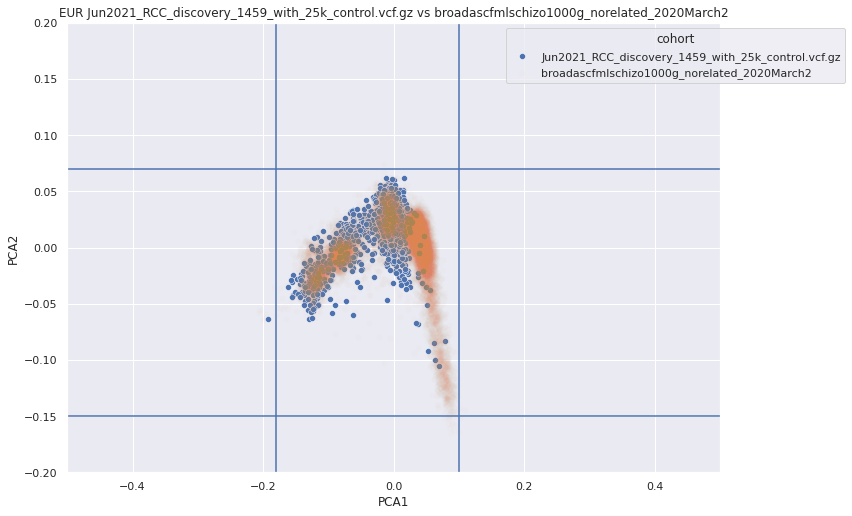

In [8]:
#Define values of PCs to exclude outliers = EUR

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=EUR_pca[EUR_pca.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=EUR_pca[EUR_pca.cohort=="control"],alpha=0.02,ax=ax)

fg.set(xlim=(-0.5,0.5))
fg.set(ylim=(-0.2,0.2))
fg.set_title("EUR "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))


EUR_PC1_min = -0.18
EUR_PC1_max = 0.1
EUR_PC2_min = -0.15
EUR_PC2_max = 0.07



plt.axvline(x= EUR_PC1_min)  #PCA1_left
plt.axvline(x=EUR_PC1_max)   #PCA1_right 
plt.axhline(y=EUR_PC2_max)   #PCA2_up 
plt.axhline(y=EUR_PC2_min)  #PCA2_down



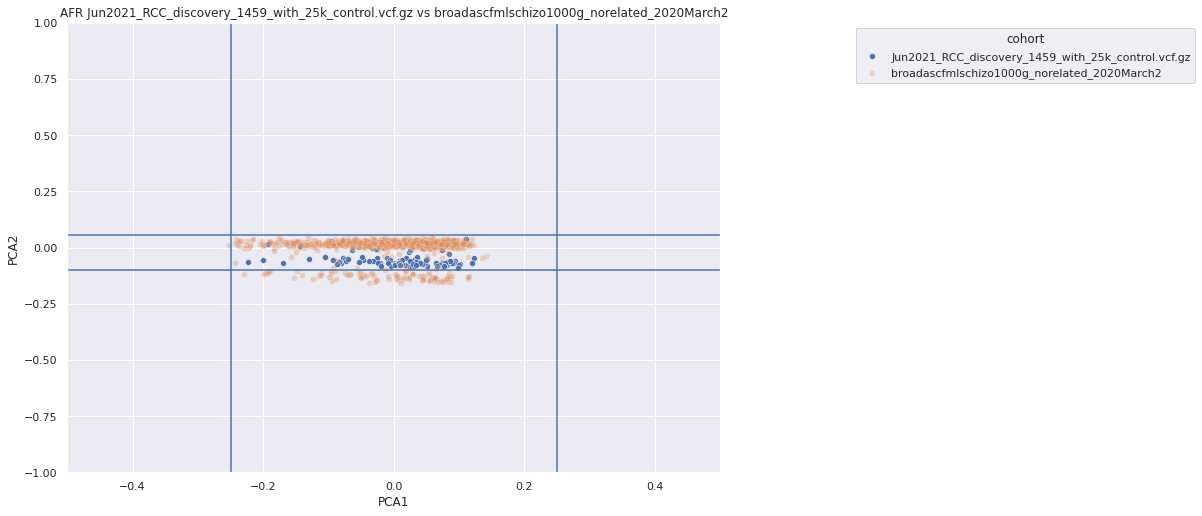

In [30]:
#Define values of PCs to exclude outliers = AFR

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=AFR_pca[AFR_pca.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=AFR_pca[AFR_pca.cohort=="control"],alpha=0.3, ax=ax)

fg.set(xlim=(-0.5,0.5))
fg.set(ylim=(-1,1))
fg.set_title("AFR "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))

AFR_PC1_min = -0.25
AFR_PC1_max = 0.25
AFR_PC2_min = -0.1
AFR_PC2_max = 0.055


plt.axvline(x= AFR_PC1_min)  #PCA1_left
plt.axvline(x=AFR_PC1_max)   #PCA1_right 
plt.axhline(y=AFR_PC2_max)   #PCA2_up 
plt.axhline(y=AFR_PC2_min)  #PCA2_down





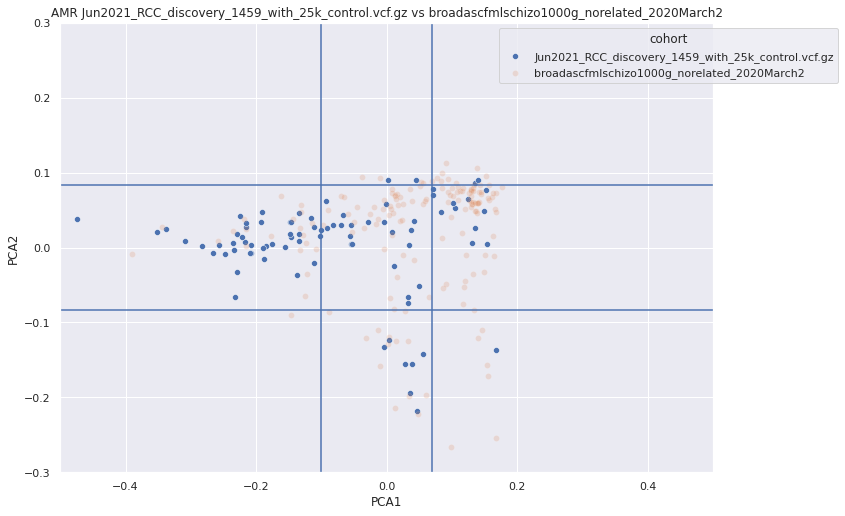

In [20]:
#Define values of PCs to exclude outliers = AMR

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=AMR_pca[AMR_pca.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=AMR_pca[AMR_pca.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.5,0.5))
fg.set(ylim=(-0.3,0.3))
fg.set_title("AMR "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))


AMR_PC1_min = -0.1
AMR_PC1_max = 0.07
AMR_PC2_min = -0.083
AMR_PC2_max = 0.083

plt.axvline(x= AMR_PC1_min)  #PCA1_left
plt.axvline(x=AMR_PC1_max)   #PCA1_right 
plt.axhline(y=AMR_PC2_max)   #PCA2_up 
plt.axhline(y=AMR_PC2_min)  #PCA2_down


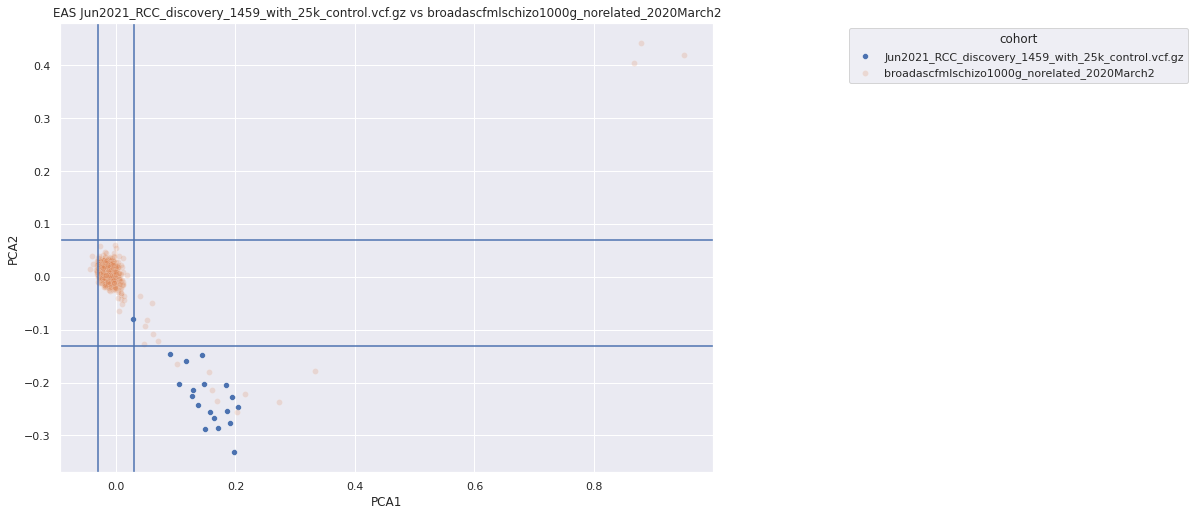

In [18]:
#Define values of PCs to exclude outliers = EAS

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=EAS_pca[EAS_pca.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=EAS_pca[EAS_pca.cohort=="control"],alpha=0.2, ax=ax)

#fg.set(xlim=(-0.2,0.2))
#fg.set(ylim=(-0.5,0.5))
fg.set_title("EAS "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))

EAS_PC1_min = -0.03
EAS_PC1_max = 0.03

EAS_PC2_min = -0.13
EAS_PC2_max = 0.07


plt.axvline(x= EAS_PC1_min)  #PCA1_left
plt.axvline(x=EAS_PC1_max)   #PCA1_right 
plt.axhline(y=EAS_PC2_max)   #PCA2_up 
plt.axhline(y=EAS_PC2_min)  #PCA2_down


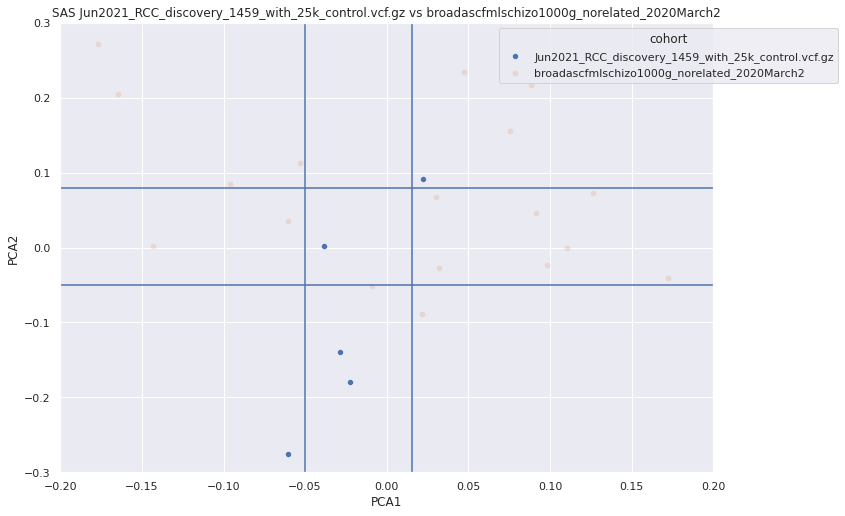

In [17]:
#Define values of PCs to exclude outliers = SAS

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=SAS_pca[SAS_pca.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=SAS_pca[SAS_pca.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.2,0.2))
fg.set(ylim=(-0.3,0.3))
fg.set_title("SAS "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))

SAS_PC1_min = -0.05
SAS_PC1_max = 0.0154
SAS_PC2_min = -0.05
SAS_PC2_max = 0.08

plt.axvline(x= SAS_PC1_min)  #PCA1_left
plt.axvline(x=SAS_PC1_max)   #PCA1_right 
plt.axhline(y=SAS_PC2_max)   #PCA2_up 
plt.axhline(y=SAS_PC2_min)  #PCA2_down





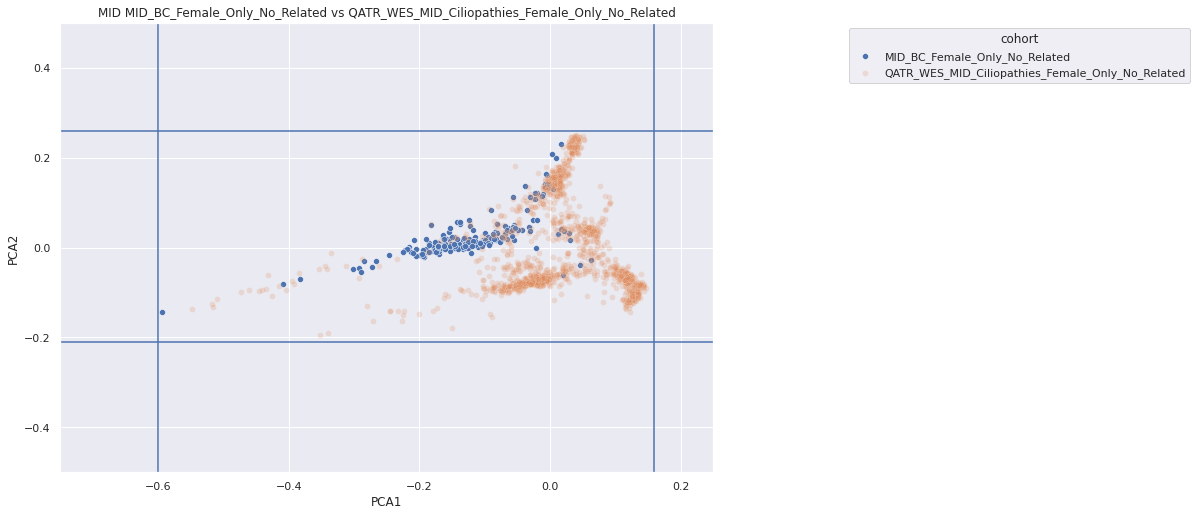

In [22]:
#Define values of PCs to exclude outliers = MID

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=MID_pca[MID_pca.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=MID_pca[MID_pca.cohort=="control"],alpha=0.2, ax=ax)

# fg.set(xlim=(-0.5,0.2))
# fg.set(ylim=(-0.5,0.5))

fg.set(xlim=(-0.75,0.25))
fg.set(ylim=(-0.5,0.5))

fg.set_title("MID "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))

MID_PC1_min = -0.6
MID_PC1_max = 0.16
MID_PC2_min = -0.21
MID_PC2_max = 0.26

plt.axvline(x= MID_PC1_min)  #PCA1_left
plt.axvline(x=MID_PC1_max)   #PCA1_right 
plt.axhline(y=MID_PC2_max)   #PCA2_up 
plt.axhline(y=MID_PC2_min)  #PCA2_down





<b> *In case you don't have all 5 ancestry groups in your cohort, comment out lines below for absent ancestries, 
    and change the dictionary defined as "PC_coord" variable </b>

In [23]:
#Save the coordinates - for RCC cases 

#EUR_coord=[EUR_PC1_min,EUR_PC1_max, EUR_PC2_min, EUR_PC2_max] 
#AFR_coord=[AFR_PC1_min,AFR_PC1_max, AFR_PC2_min, AFR_PC2_max] 
#AMR_coord=[AMR_PC1_min,AMR_PC1_max, AMR_PC2_min, AMR_PC2_max] 
#EAS_coord=[EAS_PC1_min,EAS_PC1_max, EAS_PC2_min, EAS_PC2_max] 
#SAS_coord=[SAS_PC1_min,SAS_PC1_max, SAS_PC2_min, SAS_PC2_max]
MID_coord=[MID_PC1_min,MID_PC1_max, MID_PC2_min, MID_PC2_max] 

PC_coord_row=["PC1_min","PC1_max","PC2_min","PC2_max"]

# PC_coord={"EUR":EUR_coord, "AFR":AFR_coord} #Change this accordingly
PC_coord={"MID":MID_coord}

PC_coord_df=pd.DataFrame(PC_coord)
PC_coord_df.index=PC_coord_row


PC_coord_df.to_csv("PC_coord.txt",sep="\t")
!gsutil cp "PC_coord.txt" $bucket

Copying file://PC_coord.txt [Content-Type=text/plain]...
/ [1 files][   58.0 B/   58.0 B]                                                
Operation completed over 1 objects/58.0 B.                                       


In [23]:
#Save the coordinates 

EUR_coord=[EUR_PC1_min,EUR_PC1_max, EUR_PC2_min, EUR_PC2_max] 
AFR_coord=[AFR_PC1_min,AFR_PC1_max, AFR_PC2_min, AFR_PC2_max] 
AMR_coord=[AMR_PC1_min,AMR_PC1_max, AMR_PC2_min, AMR_PC2_max] 
EAS_coord=[EAS_PC1_min,EAS_PC1_max, EAS_PC2_min, EAS_PC2_max] 
SAS_coord=[SAS_PC1_min,SAS_PC1_max, SAS_PC2_min, SAS_PC2_max] 
MID_coord=[MID_PC1_min,MID_PC1_max, MID_PC2_min, MID_PC2_max] 

PC_coord_row=["PC1_min","PC1_max","PC2_min","PC2_max"]

PC_coord={"EUR":EUR_coord, "AFR":AFR_coord, "AMR":AMR_coord, "EAS":EAS_coord, "SAS":SAS_coord} #Change this accordingly
PC_coord_df=pd.DataFrame(PC_coord)
PC_coord_df.index=PC_coord_row


PC_coord_df.to_csv("PC_coord.txt",sep="\t")
!gsutil cp "PC_coord.txt" $bucket

Copying file://PC_coord.txt [Content-Type=text/plain]...
/ [1 files][   62.0 B/   62.0 B]                                                
Operation completed over 1 objects/62.0 B.                                       


## Run pairmatch notebook and come back. 

    You should change cloud environment setting before running pairmatch notebook

For the rest of notebook including pairmatch notebook, you don't need an expensive cloud environment required for previous steps of the notebook.  
At this point, you should make a new cloud environment with Default setting that 
supports both Python and R language with moderate resource setting

## After running pairmatch notebook - Make final sample list for Variant_Level_Count

In [24]:
#Last part start here


# EUR_l=bucket+'EUR_pm_exclude_list.txt'
#AMR_l=bucket+'AMR_pm_exclude_list.txt'
# AFR_l=bucket+'AFR_pm_exclude_list.txt'
#SAS_l=bucket+'SAS_pm_exclude_list.txt'
#EAS_l=bucket+'EAS_pm_exclude_list.txt'
MID_1=bucket+'MID_pm_exclude_list.txt'


# !gsutil cp $EUR_l .
#!gsutil cp $AMR_l .
# !gsutil cp $AFR_l .
#!gsutil cp $SAS_l .
#!gsutil cp $EAS_l .
!gsutil cp $MID_l .


# exclude_df_EUR=pd.read_csv("EUR_pm_exclude_list.txt", sep="\t")
#exclude_df_AMR=pd.read_csv("AMR_pm_exclude_list.txt", sep="\t")
# exclude_df_AFR=pd.read_csv("AFR_pm_exclude_list.txt", sep="\t")
#exclude_df_SAS=pd.read_csv("SAS_pm_exclude_list.txt", sep="\t")
#exclude_df_EAS=pd.read_csv("EAS_pm_exclude_list.txt", sep="\t")
exclude_df_MID=pd.read_csv("MID_pm_exclude_list.txt", sep="\t")


def exclude_samples(Original_PCA,sample_to_exclude):
    seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures
    exclude_list=sample_to_exclude.final_ex_list.tolist()
    final_df=Original_PCA[Original_PCA['sample_original'].apply(lambda x : x not in exclude_list)]
    return final_df

# EUR_final=exclude_samples(EUR_pca,exclude_df_EUR)
# AFR_final=exclude_samples(AFR_pca,exclude_df_AFR)
#AMR_final=exclude_samples(AMR_pca,exclude_df_AMR)
#EAS_final=exclude_samples(EAS_pca,exclude_df_EAS)
#SAS_final=exclude_samples(SAS_pca,exclude_df_SAS)
MID_final=exclude_samples(MID_pca,exclude_df_MID)

def make_final_output(input_df,population):
    control_output_list=input_df.sample_original[input_df.cohort=="control"]
    control_output_list=pd.DataFrame(control_output_list)
    control_output_list=control_output_list.rename(columns={'sample_original':"original_sample"})
    control_output_list=control_output_list.rename(columns={'Inferred_ancestry':"inferred_ancestry_umap"})
    control_output_list["inferred_ancestry_umap"]=population
    
    case_output_list=input_df.sample_original[input_df.cohort==cohort_name]
    case_output_list=pd.DataFrame(case_output_list)
    case_output_list=case_output_list.rename(columns={'sample_original':"original_sample"})
    case_output_list=case_output_list.rename(columns={'Inferred_ancestry':"inferred_ancestry_umap"})
    case_output_list["inferred_ancestry_umap"]=population
    
    return control_output_list, case_output_list


# EUR_control_list, EUR_case_list = make_final_output(EUR_final,"EUR")
# AFR_control_list, AFR_case_list = make_final_output(AFR_final,"AFR")
#AMR_control_list, AMR_case_list = make_final_output(AMR_final,"AMR")
#EAS_control_list, EAS_case_list = make_final_output(EAS_final,"EAS")
#SAS_control_list, SAS_case_list = make_final_output(SAS_final,"SAS")
MID_control_list, MID_case_list = make_final_output(MID_final,"MID")


# EUR_control_list.to_csv("EUR_final_control_list.txt",sep="\t")
# AFR_control_list.to_csv("AFR_final_control_list.txt",sep="\t")
#AMR_control_list.to_csv("AMR_final_control_list.txt",sep="\t")
#EAS_control_list.to_csv("EAS_final_control_list.txt",sep="\t")
#SAS_control_list.to_csv("SAS_final_control_list.txt",sep="\t")
MID_control_list.to_csv("MID_final_control_list.txt",sep="\t")

# EUR_case_list.to_csv("EUR_final_case_list.txt",sep="\t")
# AFR_case_list.to_csv("AFR_final_case_list.txt",sep="\t")
#AMR_case_list.to_csv("AMR_final_case_list.txt",sep="\t")
#EAS_case_list.to_csv("EAS_final_case_list.txt",sep="\t")
#SAS_case_list.to_csv("SAS_final_case_list.txt",sep="\t")
MID_case_list.to_csv("MID_final_case_list.txt",sep="\t")


!gsutil cp "*list.txt" $bucket

CommandException: Wrong number of arguments for "cp" command.
Copying file://MID_final_control_list.txt [Content-Type=text/plain]...
Copying file://MID_final_case_list.txt [Content-Type=text/plain]...             
Copying file://MID_pm_exclude_list.txt [Content-Type=text/plain]...             
/ [3 files][ 29.6 KiB/ 29.6 KiB]                                                
Operation completed over 3 objects/29.6 KiB.                                     


In [5]:
#Last part start here


# EUR_l=bucket+'EUR_pm_exclude_list.txt'
# AMR_l=bucket+'AMR_pm_exclude_list.txt'
# AFR_l=bucket+'AFR_pm_exclude_list.txt'
# SAS_l=bucket+'SAS_pm_exclude_list.txt'
# EAS_l=bucket+'EAS_pm_exclude_list.txt'
MID_l=bucket+'MID_pm_exclude_list.txt'


# !gsutil cp $EUR_l .
# !gsutil cp $AMR_l .
# !gsutil cp $AFR_l .
# !gsutil cp $SAS_l .
# !gsutil cp $EAS_l .
!gsutil cp $MID_l .

# exclude_df_EUR=pd.read_csv("EUR_pm_exclude_list.txt", sep="\t")
# exclude_df_AMR=pd.read_csv("AMR_pm_exclude_list.txt", sep="\t")
# exclude_df_AFR=pd.read_csv("AFR_pm_exclude_list.txt", sep="\t")
# exclude_df_SAS=pd.read_csv("SAS_pm_exclude_list.txt", sep="\t")
# exclude_df_EAS=pd.read_csv("EAS_pm_exclude_list.txt", sep="\t")
exclude_df_MID=pd.read_csv("MID_pm_exclude_list.txt", sep="\t")


def exclude_samples(Original_PCA,sample_to_exclude):
    seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures
    exclude_list=sample_to_exclude.final_ex_list.tolist()
    final_df=Original_PCA[Original_PCA['sample_original'].apply(lambda x : x not in exclude_list)]
    return final_df

# EUR_final=exclude_samples(EUR_pca,exclude_df_EUR)
# AFR_final=exclude_samples(AFR_pca,exclude_df_AFR)
# AMR_final=exclude_samples(AMR_pca,exclude_df_AMR)
# EAS_final=exclude_samples(EAS_pca,exclude_df_EAS)
# SAS_final=exclude_samples(SAS_pca,exclude_df_SAS)
MID_final=exclude_samples(SAS_pca,exclude_df_SAS)


def make_final_output(input_df,population):
    control_output_list=input_df.sample_original[input_df.cohort=="control"]
    control_output_list=pd.DataFrame(control_output_list)
    control_output_list=control_output_list.rename(columns={'sample_original':"original_sample"})
    control_output_list=control_output_list.rename(columns={'Inferred_ancestry':"inferred_ancestry_umap"})
    control_output_list["inferred_ancestry_umap"]=population
    
    case_output_list=input_df.sample_original[input_df.cohort==cohort_name]
    case_output_list=pd.DataFrame(case_output_list)
    case_output_list=case_output_list.rename(columns={'sample_original':"original_sample"})
    case_output_list=case_output_list.rename(columns={'Inferred_ancestry':"inferred_ancestry_umap"})
    case_output_list["inferred_ancestry_umap"]=population
    
    return control_output_list, case_output_list


# EUR_control_list, EUR_case_list = make_final_output(EUR_final,"EUR")
# AFR_control_list, AFR_case_list = make_final_output(AFR_final,"AFR")
# AMR_control_list, AMR_case_list = make_final_output(AMR_final,"AMR")
# EAS_control_list, EAS_case_list = make_final_output(EAS_final,"EAS")
# SAS_control_list, SAS_case_list = make_final_output(SAS_final,"SAS")
MID_control_list, MID_case_list = make_final_output(MID_final,"MID")


# EUR_control_list.to_csv("EUR_final_control_list.txt",sep="\t")
# AFR_control_list.to_csv("AFR_final_control_list.txt",sep="\t")
# AMR_control_list.to_csv("AMR_final_control_list.txt",sep="\t")
# EAS_control_list.to_csv("EAS_final_control_list.txt",sep="\t")
# SAS_control_list.to_csv("SAS_final_control_list.txt",sep="\t")
MID_control_list.to_csv("MID_final_control_list.txt",sep="\t")


# EUR_case_list.to_csv("EUR_final_case_list.txt",sep="\t")
# AFR_case_list.to_csv("AFR_final_case_list.txt",sep="\t")
# AMR_case_list.to_csv("AMR_final_case_list.txt",sep="\t")
# EAS_case_list.to_csv("EAS_final_case_list.txt",sep="\t")
# SAS_case_list.to_csv("SAS_final_case_list.txt",sep="\t")
MID_case_list.to_csv("MID_final_case_list.txt",sep="\t")



!gsutil cp "*list.txt" $bucket

Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/EUR_pm_exclude_list.txt...
/ [1 files][  2.2 KiB/  2.2 KiB]                                                
Operation completed over 1 objects/2.2 KiB.                                      
Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/AMR_pm_exclude_list.txt...
/ [1 files][  880.0 B/  880.0 B]                                                
Operation completed over 1 objects/880.0 B.                                      
Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/AFR_pm_exclude_list.txt...
/ [1 files][  762.0 B/  762.0 B]                                                
Operation c

In [3]:
bucket ='gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/'

In [10]:
er=bucket+'*list.txt'

In [27]:
# EUR_case_list=pd.read_table("EUR_final_case_list.txt",sep="\t")
# EUR_control_list=pd.read_table("EUR_final_control_list.txt",sep="\t")

# AFR_case_list=pd.read_table("AFR_final_case_list.txt",sep="\t")
# AFR_control_list=pd.read_table("AFR_final_control_list.txt",sep="\t")

MID_case_list=pd.read_table("MID_final_case_list.txt",sep="\t")
MID_control_list=pd.read_table("MID_final_control_list.txt",sep="\t")

In [28]:
# len(EUR_case_list),len(EUR_control_list),len(AFR_case_list),len(AFR_control_list)
len(MID_case_list),len(MID_control_list)

(215, 1290)

In [18]:
case_final=pd.concat([EUR_case_list,AFR_case_list])
control_final=pd.concat([EUR_control_list,AFR_control_list])

In [21]:
case_final.to_csv("Discovery_case_final_list_ratio.txt",sep="\t",index=False)
control_final.to_csv("Discovery_control_final_list_ratio.txt",sep="\t",index=False)

!gsutil cp "*list_ratio.txt" $bucket

Copying file://Discovery_control_final_list_ratio.txt [Content-Type=text/plain]...
Copying file://Discovery_case_final_list_ratio.txt [Content-Type=text/plain]... 
/ [2 files][202.3 KiB/202.3 KiB]                                                
Operation completed over 2 objects/202.3 KiB.                                    


In [12]:
EUR_l=bucket+'*list.txt'
!gsutil cp $er .

Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/AFR_final_case_list.txt...
Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/AFR_final_control_list.txt...
Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/AFR_pm_exclude_list.txt...
Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/AMR_final_case_list.txt...
/ [4 files][ 22.6 KiB/ 22.6 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
se

In [36]:
##Check final samplee count for controls 
len(EUR_control_list),len(AFR_control_list)#,len(AMR_control_list),len(EAS_control_list),len(SAS_control_list)

(8463, 938)

In [37]:
##Check final samplee count for cases
len(EUR_case_list),len(AFR_case_list)#,len(AMR_case_list),len(EAS_case_list),len(SAS_case_list)

(1209, 134)

## (Optional) Plot PCs after outlier exclusion

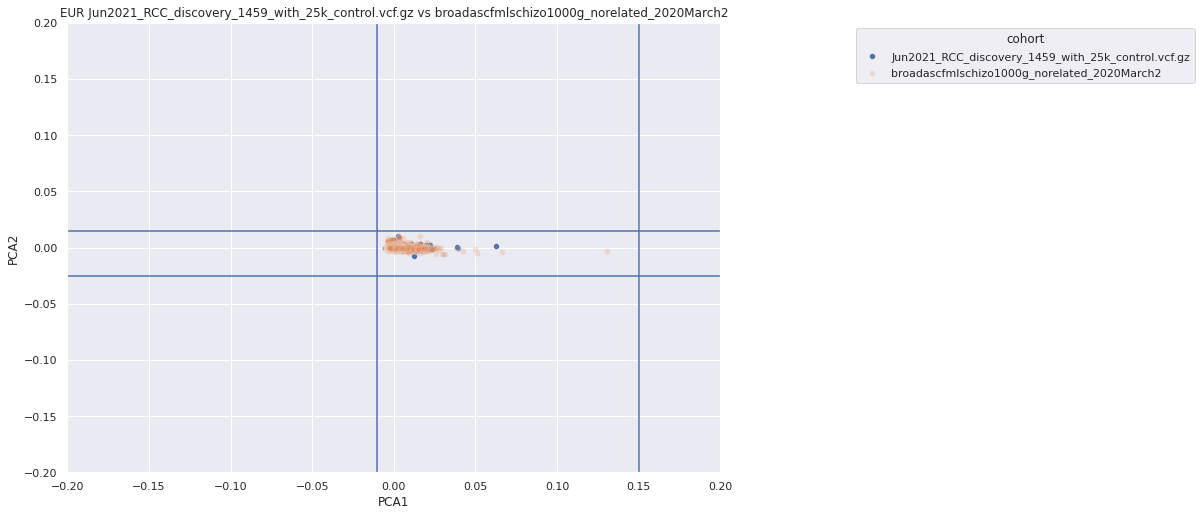

In [14]:
#Plot EUR after exclusion


seaborn.set(rc={'figure.figsize':(11.7,8.27)}) 

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=EUR_final[EUR_final.cohort==cohort_name],alpha=1.0,sizes=(20,20))
fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=EUR_final[EUR_final.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.2,0.2))
fg.set(ylim=(-0.2,0.2))
fg.set_title("EUR "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))



plt.axvline(x= EUR_PC1_min)  #PCA1_left
plt.axvline(x=EUR_PC1_max)   #PCA1_right 
plt.axhline(y=EUR_PC2_max)   #PCA2_up 
plt.axhline(y=EUR_PC2_min)  #PCA2_down


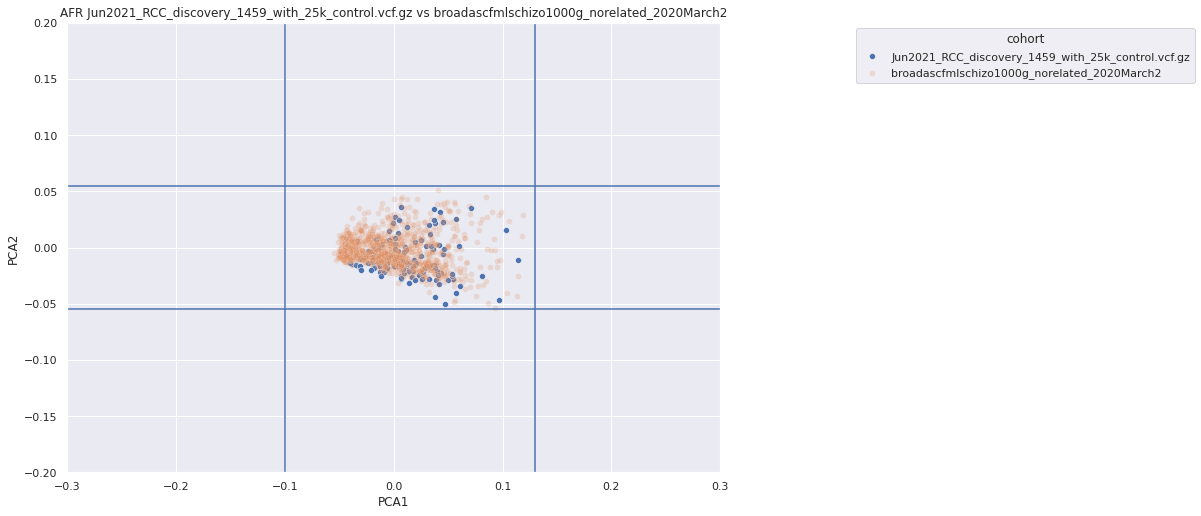

In [16]:
#Plot AFR after exclusion

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=AFR_final[AFR_final.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=AFR_final[AFR_final.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.3,0.3))
fg.set(ylim=(-0.2,0.2))
fg.set_title("AFR "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))

plt.axvline(x= AFR_PC1_min)  #PCA1_left
plt.axvline(x=AFR_PC1_max)   #PCA1_right 
plt.axhline(y=AFR_PC2_max)   #PCA2_up 
plt.axhline(y=AFR_PC2_min)  #PCA2_down


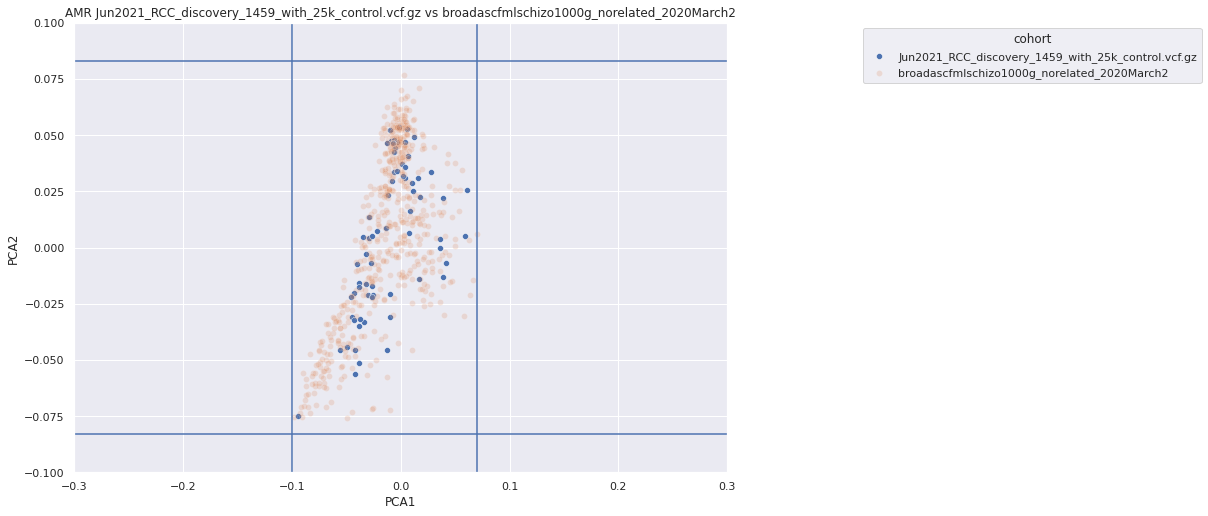

In [17]:
#Plot AMR after exclusion

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=AMR_final[AMR_final.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=AMR_final[AMR_final.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.3,0.3))
fg.set(ylim=(-0.1,0.1))
fg.set_title("AMR "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))

plt.axvline(x= AMR_PC1_min)  #PCA1_left
plt.axvline(x=AMR_PC1_max)   #PCA1_right 
plt.axhline(y=AMR_PC2_max)   #PCA2_up 
plt.axhline(y=AMR_PC2_min)  #PCA2_down

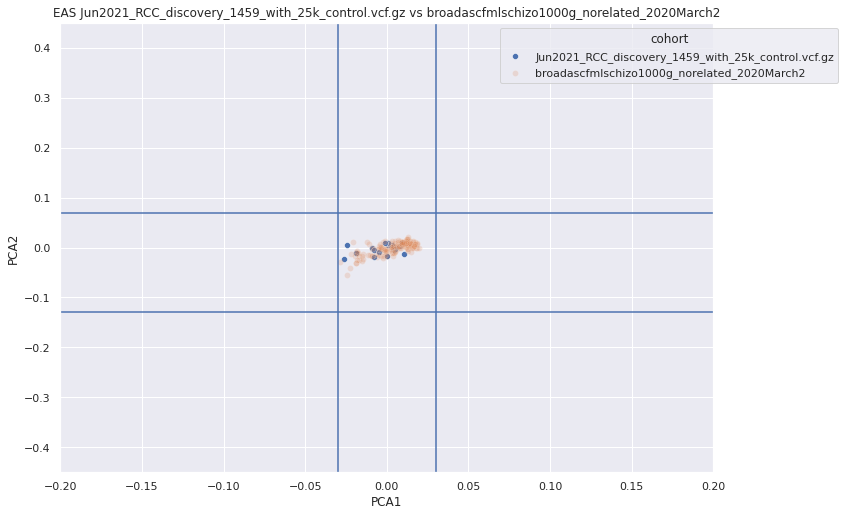

In [18]:
#Plot EAS after exclusion

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=EAS_final[EAS_final.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=EAS_final[EAS_final.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.2,0.2))
fg.set(ylim=(-0.45,0.45))
fg.set_title("EAS "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))
plt.axvline(x= EAS_PC1_min)  #PCA1_left
plt.axvline(x=EAS_PC1_max)   #PCA1_right 
plt.axhline(y=EAS_PC2_max)   #PCA2_up 
plt.axhline(y=EAS_PC2_min)  #PCA2_down



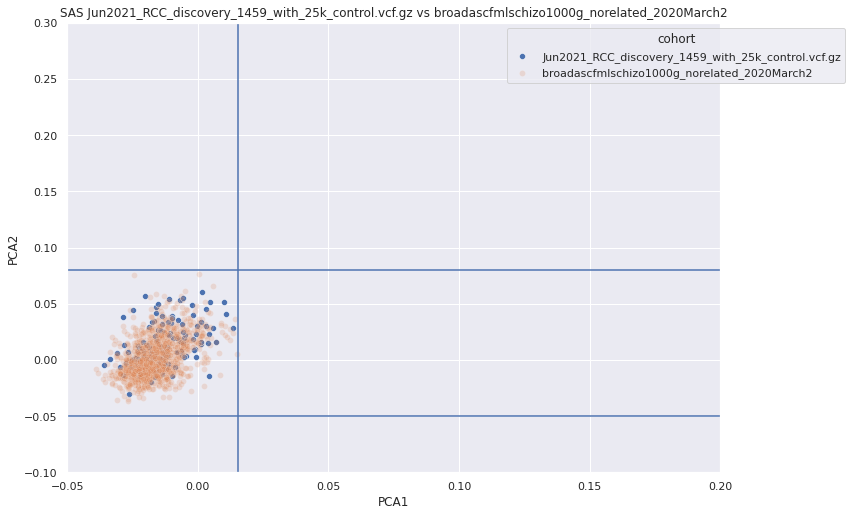

In [19]:
#Plot SAS after exclusion

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=SAS_final[SAS_final.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=SAS_final[SAS_final.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.05,0.2))
fg.set(ylim=(-0.1,0.3))
fg.set_title("SAS "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))

plt.axvline(x= SAS_PC1_min)  #PCA1_left
plt.axvline(x=SAS_PC1_max)   #PCA1_right 
plt.axhline(y=SAS_PC2_max)   #PCA2_up 
plt.axhline(y=SAS_PC2_min)  #PCA2_down


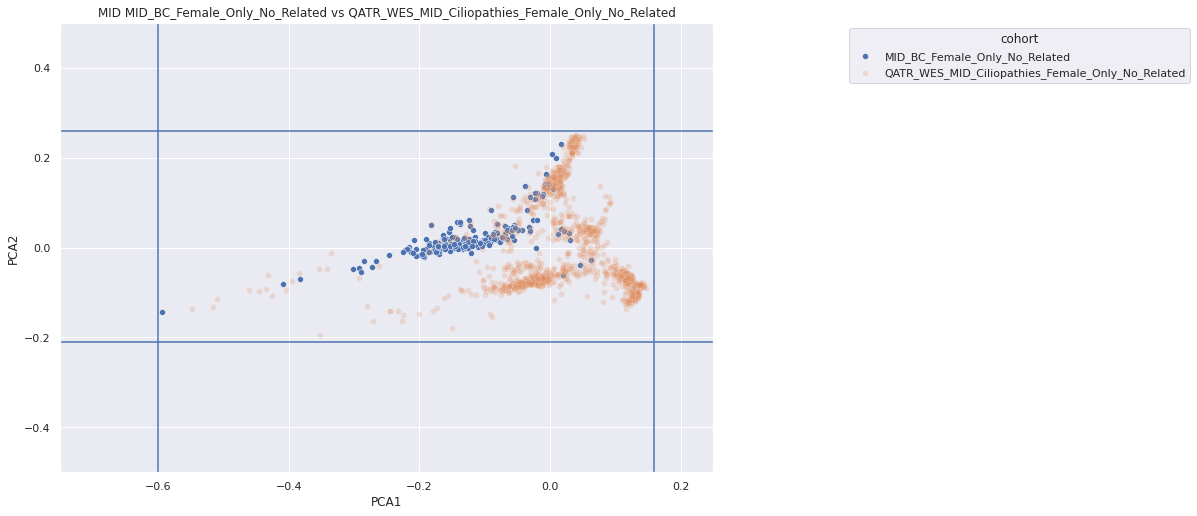

In [26]:
#Plot MID after exclusion


seaborn.set(rc={'figure.figsize':(11.7,8.27)}) 

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=MID_final[MID_final.cohort==cohort_name],alpha=1.0,sizes=(20,20))
fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=MID_final[MID_final.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.75,0.25))
fg.set(ylim=(-0.5,0.5))
fg.set_title("MID "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))


plt.axvline(x= MID_PC1_min)  #PCA1_left
plt.axvline(x=MID_PC1_max)   #PCA1_right 
plt.axhline(y=MID_PC2_max)   #PCA2_up 
plt.axhline(y=MID_PC2_min)  #PCA2_down


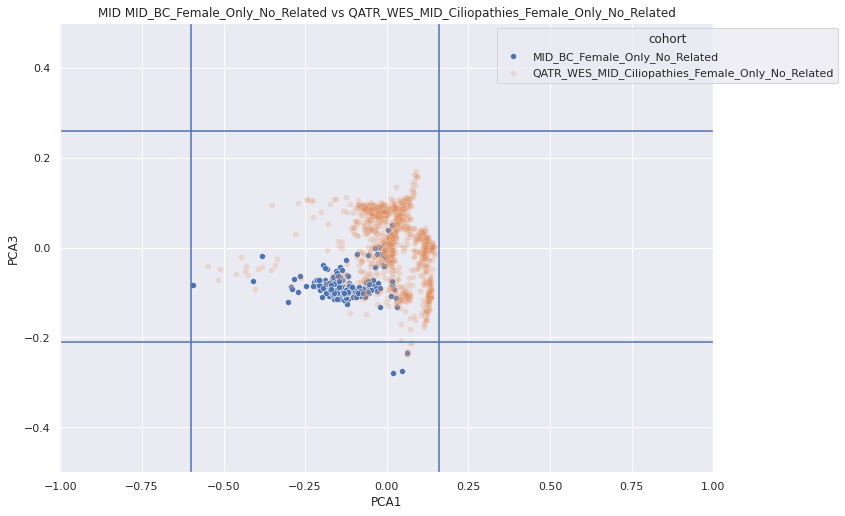

In [32]:
#Plot MID after exclusion


seaborn.set(rc={'figure.figsize':(11.7,8.27)}) 

ax=seaborn.scatterplot(x="PCA1", y="PCA3", data=MID_final[MID_final.cohort==cohort_name],alpha=1.0,sizes=(20,20))
fg=seaborn.scatterplot(x="PCA1", y="PCA3", data=MID_final[MID_final.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-1,1))
fg.set(ylim=(-0.5,0.5))
fg.set_title("MID "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))


plt.axvline(x= MID_PC1_min)  #PCA1_left
plt.axvline(x=MID_PC1_max)   #PCA1_right 
plt.axhline(y=MID_PC2_max)   #PCA2_up 
plt.axhline(y=MID_PC2_min)  #PCA2_down
